<a href="https://colab.research.google.com/github/mgmeti/projects-/blob/main/Financial_Analysis_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install these libraries while running the file

In [14]:
# !pip install yfinance
#!pip install --upgrade keras-tuner

In [31]:

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import plotly.express as px

import plotly.graph_objects as go
import datetime as dt

In [16]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [17]:
stock_data = yf.download('MSFT', start='2017-12-01', end='2023-12-01')
print(stock_data.shape)
stock_data.tail()

[*********************100%%**********************]  1 of 1 completed
(1509, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-24,377.329987,377.970001,375.140015,377.429993,377.429993,10176600
2023-11-27,376.779999,380.640015,376.200012,378.609985,378.609985,22179200
2023-11-28,378.350006,383.000000,378.160004,382.700012,382.700012,20453100
2023-11-29,383.760010,384.299988,377.440002,378.850006,378.850006,28963400
2023-11-30,378.489990,380.089996,375.470001,378.910004,378.910004,30554400


## Data Exploration

In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2017-12-01 to 2023-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1509 non-null   float64
 1   High       1509 non-null   float64
 2   Low        1509 non-null   float64
 3   Close      1509 non-null   float64
 4   Adj Close  1509 non-null   float64
 5   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.5 KB


In [19]:
print(stock_data.index.min())
print(stock_data.index.max())

2017-12-01 00:00:00
2023-11-30 00:00:00


## Visualizing Stock Prices History

<Axes: xlabel='Date'>

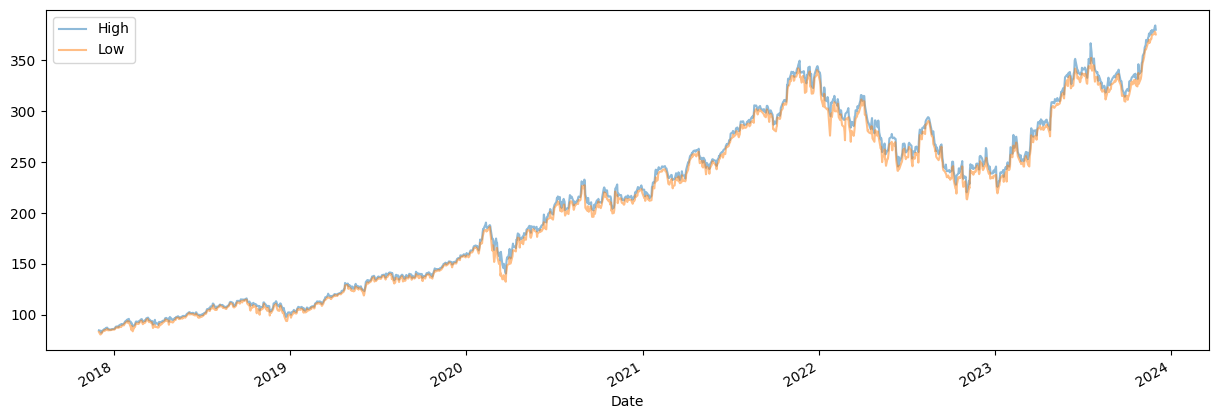

In [20]:
stock_data[['High', 'Low']].plot(figsize = (15, 5), alpha = 0.5)

<Axes: xlabel='Date'>

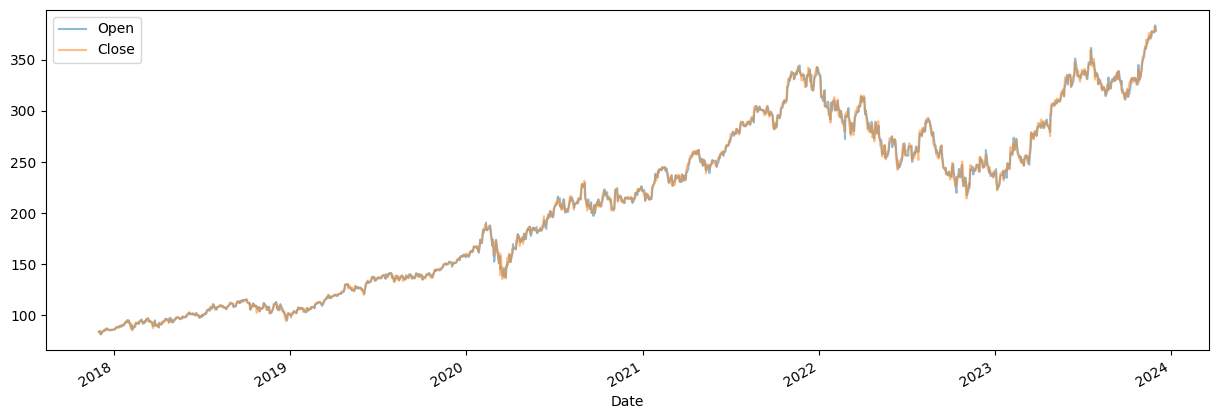

In [21]:
stock_data[['Open', 'Close']].plot(figsize = (15, 5), alpha = 0.5)

In [22]:
fig = px.line(stock_data,  y="Close", title='Stock price chart')
fig.show()

## Analysis of Stock Data:

In [23]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

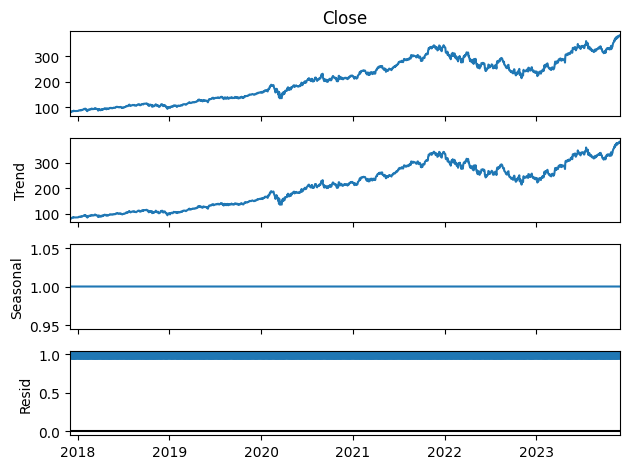

In [24]:
results = seasonal_decompose(stock_data['Close'], model='multiplicative', period=1)
results.plot()
pyplot.show()

* The graph displays the average closing price of Microsoft (MSFT) from 2018 to
2023, showing significant fluctuations but generally upward trends.
* The stock price reached a high of \$384.30 in 2021 but has since fallen back to around \$370.00. Although the stock price is likely to fluctuate in the future, Microsoft's strong track record suggests it will continue to trend upwards over the long term.
* The graph includes the closing price, residual, seasonal component, and trend component, which represent the difference between the actual and predicted stock price based on trend and seasonal factors. The trend component represents the long-term direction of the stock price.

## Preprocessing

In [32]:
# Create a new dataframe with only the 'Close' column
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil(0.8 * len(dataset)))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train datasets to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Model with keras tuner

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from kerastuner.tuners import RandomSearch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Function to build the regression model
def build_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   kernel_initializer='glorot_uniform',
                   input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                   kernel_initializer='glorot_uniform',
                   return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=512, step=32),
                   kernel_initializer='glorot_uniform',
                   return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=hp.Int('units_4', min_value=32, max_value=512, step=32),
                   kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')

    return model

# Instantiate the tuner for random search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='financial_analysis',
    seed=42,
)

# Perform the random search
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)


In [53]:
# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 320)           451840    
                                                                 
 dropout_1 (Dropout)         (None, 60, 320)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           229888    
                                                                 
 dropout_2 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 160)               1

 ## Training

In [52]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the best model with early stopping
best_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
29/29 [==============================] - 20s 701ms/step - loss: 7.0670e-04 - val_loss: 0.0015
Epoch 2/100
29/29 [==============================] - 21s 731ms/step - loss: 6.5077e-04 - val_loss: 0.0023
Epoch 3/100
29/29 [==============================] - 17s 576ms/step - loss: 7.1683e-04 - val_loss: 0.0013
Epoch 4/100
29/29 [==============================] - 17s 581ms/step - loss: 6.5364e-04 - val_loss: 0.0014
Epoch 5/100
29/29 [==============================] - 19s 651ms/step - loss: 5.9724e-04 - val_loss: 0.0013
Epoch 6/100
29/29 [==============================] - 18s 615ms/step - loss: 5.7492e-04 - val_loss: 0.0013
Epoch 7/100
29/29 [==============================] - 17s 588ms/step - loss: 6.9536e-04 - val_loss: 0.0013
Epoch 8/100
29/29 [==============================] - 17s 594ms/step - loss: 5.8957e-04 - val_loss: 0.0013
Epoch 9/100
29/29 [==============================] - 19s 670ms/step - loss: 6.0795e-04 - val_loss: 0.0024
Epoch 10/100
29/29 [==========================

## Prediction

In [54]:
# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]
# Create the x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the x_test dataset to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Predict the next day's closing price
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)


# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = best_model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted Price after Month:', pred_price)

1/1 [==============================] - 0s 48ms/step
Predicted Price after Month: [[355.77716]]


## Evaluation

RMSE: 15.511408399964013


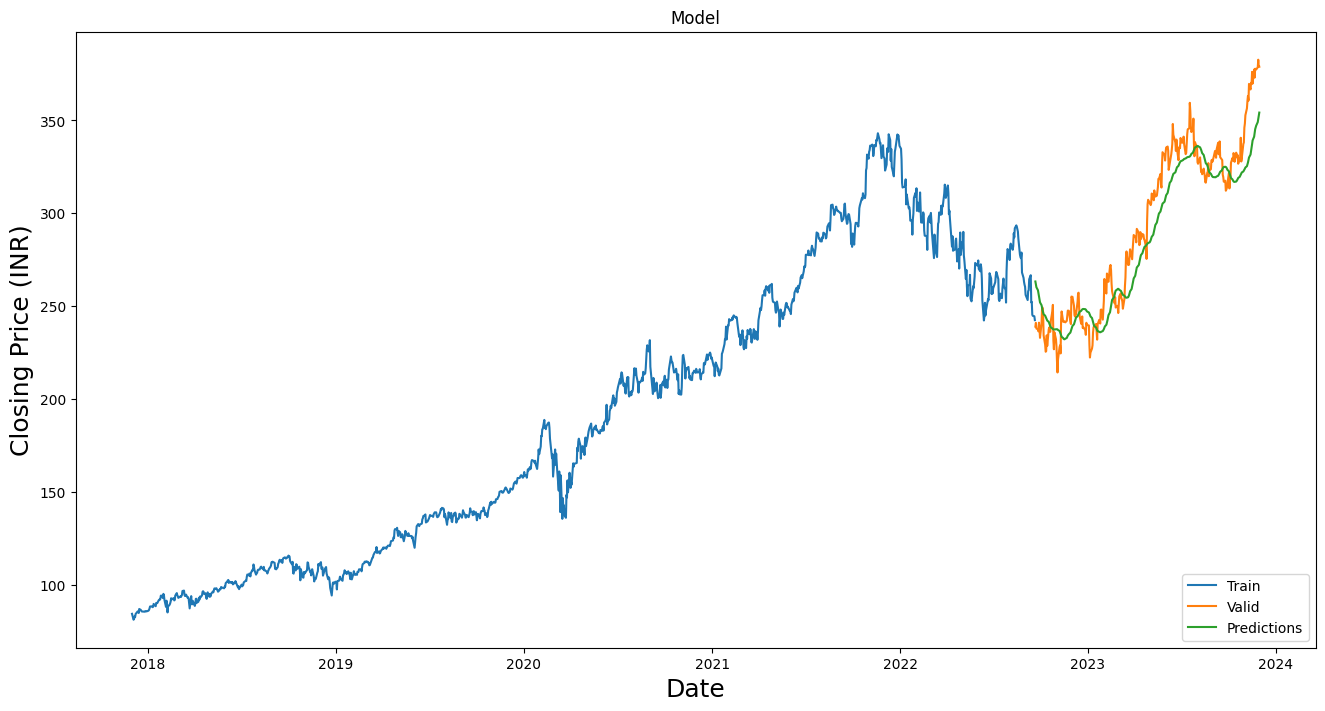

In [55]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print('RMSE:', rmse)

# Visualize the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (INR)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

# Model build uniform units





In [ ]:

# Initializing the model
regression = Sequential()

# First LSTM layer with 0.2% dropout
regression.add(LSTM(units=50, return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(x_train.shape[1], 1)))
regression.add(Dropout(0.2))

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50, kernel_initializer='glorot_uniform', return_sequences=True))
regression.add(Dropout(0.2))

# Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50, kernel_initializer='glorot_uniform', return_sequences=True))
regression.add(Dropout(0.2))

# Fourth LSTM layer with 0.2% dropout
regression.add(LSTM(units=50, kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))

# Output layer, no activation specified for a continuous value model
regression.add(Dense(units=1))

# Compiling the network
regression.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
regression.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

 ## Training

In [ ]:
# Train the regression model with updated parameters
regression.fit(x_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
36/36 [==============================] - 16s 148ms/step - loss: 0.0385
Epoch 2/100
36/36 [==============================] - 5s 126ms/step - loss: 0.0037
Epoch 3/100
36/36 [==============================] - 6s 178ms/step - loss: 0.0041
Epoch 4/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0031
Epoch 5/100
36/36 [==============================] - 5s 127ms/step - loss: 0.0033
Epoch 6/100
36/36 [==============================] - 7s 184ms/step - loss: 0.0032
Epoch 7/100
36/36 [==============================] - 5s 125ms/step - loss: 0.0026
Epoch 8/100
36/36 [==============================] - 5s 129ms/step - loss: 0.0028
Epoch 9/100
36/36 [==============================] - 6s 180ms/step - loss: 0.0029
Epoch 10/100
36/36 [==============================] - 5s 130ms/step - loss: 0.0024
Epoch 11/100
36/36 [==============================] - 5s 151ms/step - loss: 0.0027
Epoch 12/100
36/36 [==============================] - 6s 161ms/step - loss: 0.0024
Epoch 13/100

## Prediction

In [ ]:
# Create the testing dataset
test_data = scaled_data[training_data_len - 60:, :]
# Create the x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the x_test dataset to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = regression.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 3s 53ms/step


In [ ]:
# Predict the next day's closing price
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)


# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = regression.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted Price after Month:', pred_price)

1/1 [==============================] - 0s 74ms/step
Predicted Price after Month: [[364.27945]]


## Evaluation

RMSE: 10.100275685568532


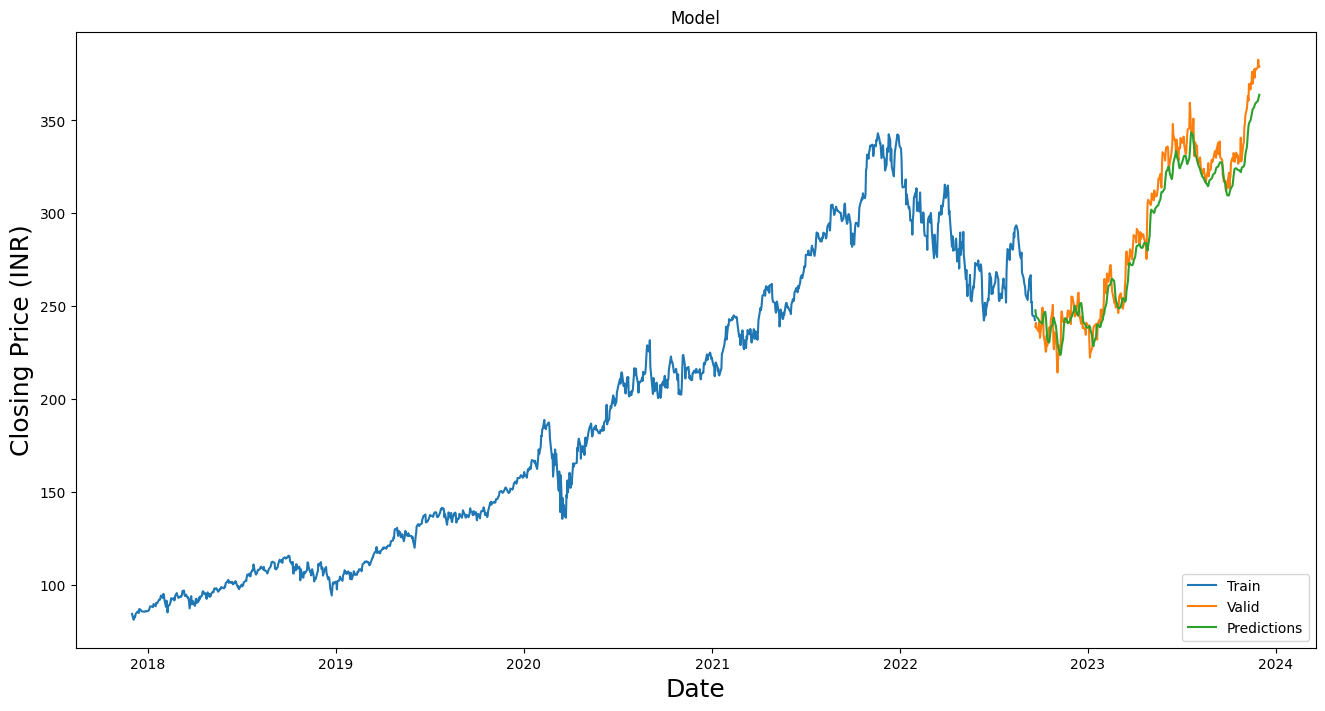

In [46]:

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print('RMSE:', rmse)

# Visualize the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (INR)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()






Analysis:

* The Keras Tuner Model has a higher predicted price after a month compared to the Regression Model.
* The RMSE for the Keras Tuner Model is higher, indicating a larger deviation between the predicted and actual values.
* The Regression Model with LSTM and uniform units performed better with a lower RMSE, suggesting a closer fit to the actual data.
